# MS-E2122 - Nonlinear Optimization
Prof. Fabricio Oliveira (and Nuutti Hyvönen)

## Project Assignment 2 - ADMM

In [1]:
using JuMP
using Ipopt
using Random
using Test
using LinearAlgebra

The code below generates the structure used to create and give instances as input to the routines we will implement later.

In [2]:
struct Instance
    I  # Supplier index set
    J  # Client index set
    S  # Scenario index set
    C  # Unit capacity costs of suppliers
    D  # Client demands in all scenarios
    Q  # Unit costs of unfulfilled demand
    P  # Scenario probabilities
    F  # Unit costs to fulfil demands
    Bs # Max supplier capacities
    Bc # Max budget (cost) for capacity acquisition
end

function generate_instance(nI, nJ, nS)
    Random.seed!(1)
    I = 1:nI                          # Supplier index set
    J = 1:nJ                          # Client index set
    S = 1:nS                          # Scenario index set
    C = rand(5:20, nI)                # Unit capacity costs of suppliers
    D = rand(nJ,nS).*rand(5:40, nJ)   # Client demands in all scenarios
    Q = rand(4000:90000, nJ)          # Unit costs of unfulfilled demand
    P = ones(nS).*1/nS                # Scenario probabilities
    F = rand(2:30, (nI,nJ))           # Unit costs to fulfil demands
    Bs = rand(10:80, nI)              # Max supplier capacities
    Bc = 1500                         # Max budget (cost) for capacity acquisition

    Instance(I, J, S, C, D, Q, P, F, Bs, Bc)
end

function unpack_instance(instance)
    return (instance.I, 
            instance.J, 
            instance.S, 
            instance.C, 
            instance.D, 
            instance.Q, 
            instance.P, 
            instance.F, 
            instance.Bs, 
            instance.Bc
            )
end

function print_solution_stats(x, C)
    # Print capacity cost.
    fval = dot(C, value.(x))   # Optimal cost of reserved capacities                        
    println("Optimal cost of reserved capacities: ", fval)

    # Print optimal solution 
    println("Optimal solution:")
    for i = 1:length(x)
        println("x[$i] = ", round(value(x[i]),digits=2))
    end
end

print_solution_stats (generic function with 1 method)

Here is the implementaiton of the stochastic capacity expansion problem as described. You can use this as a reference for benchmarking the correctness and the performance of your model.

In [3]:
# Function to solve an instance of the full-scale model
function full_scale_model(instance; log=false)
    
    # Unpacking instance information
    (I, J, S, C, D, Q, P, F, Bs, Bc) = unpack_instance(instance)

    # We first solve the problem formulation directly without ADMM
    model = Model(Ipopt.Optimizer)                      # We use Ipopt solver to compare with ADMM                                                       

    # Variables
    @variable(model, x[i in I] >= 0)                    # Reserved capacity variables
    @variable(model, y[i in I, j in J, s in S] >= 0)    # Demand fulfilment variables
    @variable(model, u[j in J, s in S] >= 0)            # Unfulfilled demand variables

    # Objective: Minimize the total phase 1 + phase 2 costs over all scenarios
    @objective(model, Min,
          sum(C[i]*x[i] for i in I) +
          sum(P[s]*F[i,j]*y[i,j,s] for s in S, i in I, j in J) + 
          sum(P[s]*Q[j]*u[j,s] for s in S, j in J))

    # Constraints
    @constraint(model, [i in I], x[i] <= Bs[i])          # Max capacity constraint
    @constraint(model, sum(C[i]*x[i] for i in I) <= Bc)  # Max capacity budget (cost) constraint

    # Capacity reserve limit constraint for each supplier i in each scenario s
    @constraint(model, [i in I, s in S], sum(y[i,j,s] for j in J) <= x[i])

    # Demand balance constraint (u[j,s] is unfulfilled demand of client j in scenario s)
    @constraint(model, DemBal[j in J, s in S], sum(y[i,j,s] for i in I) + u[j,s] == D[j,s])
 
    if !log
        set_silent(model)    # Solve the problem
    end
    
    optimize!(model)         # Solve the problem
    
    print_solution_stats(x, C)
    return value.(x) 
    
end

full_scale_model (generic function with 1 method)

We can then generate one "test" instance that will serve as reference for us.

In [4]:
Random.seed!(1)
@time test_instance = generate_instance(15,20,10);

  0.000070 seconds (19 allocations: 23.461 KiB)


To time these functions, we will use the `@time` macro since the operation takes several seconds and doing multiple replications would be time consuming. Notice however that Julia uses JIT compilation, so the first time the function is run, it is also compiled. To discount this time from the timing, you can simply remove the percentage associated with compilation time. 

Of course, once you have run the function on this test instance, it has been compiled and you don't then need to worry about compilation times when considering the actual instances later.

In [5]:
@time x_full = full_scale_model(test_instance);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Optimal cost of reserved capacities: 1500.000016297421
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 38.0
x[4] = 37.0
x[5] = 15.0
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 12.0
x[11] = 0.0
x[12] = 0.0
x[13] = 29.2
x[14] = 0.0
x[15] = 39.0
 52.253398 seconds (94.09 M allocations: 5.462 GiB, 4.77% gc time, 40.69% compilation time)


## ADMM implementation

Next we will implement the function that employs ADMM to solve the stochastic capacity expansion problem. Notice that you are required to implement:
1. The objective function of the augmented Lagrangian form
2. The combined primal and dual residual
3. The z-update
4. The dual update.

The input of the function is an `Instance` struct. The output is the value of the JuMP variable `x_s` and the number of iterations `k`.

In [6]:
function admm_model(instance; ρ=1.0, N=200, ϵ=1e-2)   
    
    # Unpacking instance information
    (I, J, S, C, D, Q, P, F, Bs, Bc) = unpack_instance(instance)
    nI = length(I) 
    nJ = length(J)
    nS = length(S)

    # NOTE: ADMM approach starts from here. Complete the missing code parts that
    #       are requested. NOTE: Use Exercise 10.1 as a reference.

    # Problem parameters and memory allocation. NOTE: Compare with Exercise 10.1
    x_s  = zeros(nI, nS)  # Store each x vector in (x,y)-steps of each scenario
    v_s  = zeros(nI, nS)  # Store each v vector in v-steps of each scenario
    z    = zeros(nI)      # Store z vectors at each ADNM iteration
    
    # Main loop
    for k = 1:N
        # Loop for solving each (x,y) step separately for each scenario s in S.
        for s in S   

            # Model to solve (x,y)-step of the current scenario subproblem s
            scen_m = Model(optimizer_with_attributes(Ipopt.Optimizer)) 
            
            @variable(scen_m, x[i in I] >= 0)                    # Reserved capacity variables
            @variable(scen_m, y[i in I, j in J] >= 0)            # Demand fulfilment variables
            @variable(scen_m, u[j in J] >= 0)                    # Unfulfilled demand variables

            @constraint(scen_m, [i in I], x[i] <= Bs[i])          # Max capacity constraint
            @constraint(scen_m, sum(C[i]*x[i] for i in I) <= Bc)  # Max capacity budget (cost)
            
            # Capacity reserve limit constraint for each supplier i
            @constraint(scen_m, [i in I], sum(y[i,j] for j in J) <= x[i])
            
            # Demand balance constraint (u[j] is unfulfilled demand of client j)
            @constraint(scen_m, [j in J], sum(y[i,j] for i in I) == D[j,s] - u[j])

            # TODO: Complete this objective to compute (x,y)-step for the
            #       current scenario. 
            @objective(scen_m, Min, sum(C[i]*x[i] for i in I)+ P[s]*(sum(F[i,j]*y[i,j] for j in J,i in I) +
                       sum(Q[j]*u[j] for j in J))+(v_s[:,s])'*(x-z)+0.5*ρ*dot(x-z,x-z))                      




            # Solve the (x,y) step for the current scenario
            set_silent(scen_m)
            optimize!(scen_m) 

            # Store the value of x for the current scenario
            x_s[:,s] = value.(x[:])
        end

        # Compute primal and dual residuals. We use array to exploit parallelism
        tol = zeros(nS)
        
        # TODO: Complete the computation of the residual for each s.
        for s in S
           tol[s]=P[s]*ρ*norm(x_s[:,s]-z)  
        end
        
        # Total residual = sum of subproblem residuals
        tol = sum(tol[s] for s in S)

        # Print current progress
        println("iteration: $k | residual: $tol")
        # Stopping condition: if primal + dual residual is small enough
        if tol < 1e-1
            print_solution_stats(sum(x_s,dims=2)./nS, C)
            return (value.(x_s), k)
        end

        # TODO: Compute z-step for this iteration
        z = sum(P[s]*x_s[:,s] for s in S)

        # TODO: Update v-step separately for each scenario
        for s in S
             v_s[:,s]=v_s[:,s]+ρ*(x_s[:,s]-z)
        end
        
        # Check whether the iterations limit is exceeded while stopping condition isn't met
        if k == N 
            println("Algorithm terminated because of exceeding the limit of iterations($N))")
        end
    end

    print_solution_stats(sum(x_s,dims=2)./nS, tend, C)
    return (value.(x_s), k) 
end

admm_model (generic function with 1 method)

As before, let us test our implementation on a test instance. For verifying our implementation, we will compare the solution of the full scale model and the ADMM model to verify correctness.

In [7]:
@time (x_s, k) = admm_model(test_instance);

iteration: 1 | residual: 83.69578645542046
iteration: 2 | residual: 4.070121723735203
iteration: 3 | residual: 0.9427270712204008
iteration: 4 | residual: 0.26040826348846735
iteration: 5 | residual: 0.015299024083807424
Optimal cost of reserved capacities: 1500.000012561272
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 38.0
x[4] = 37.0
x[5] = 15.0
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 12.0
x[11] = 0.0
x[12] = 0.0
x[13] = 29.2
x[14] = 0.0
x[15] = 39.0
 12.624029 seconds (6.15 M allocations: 382.819 MiB, 2.94% gc time, 43.11% compilation time)


In [8]:
#=The actual solution is the average of the scenario-dependent solutions (with 10 scenarios for the test instance). Notice that they should all match if the
primal residual is sufficiently small=#
x_admm = sum(x_s, dims=2)./10

# Test whether the solutions match, within a specific tolerance
@test norm(x_full - x_admm) ≤ 0.1

Test Passed

We are now ready to make comparisons considering different instances (with 50, 75 and 100 scenarios). Make sure you have executed your functions before in the test instance, so Julia JIT compiler has the function ready and you can measure only execution time. (Notice that the time macro will inform any compiling time otherwise).

Use instances below to perform your computational experiments. Use the small instances to try different values of $\rho \in [0.5 , 100]$. Some ideas for analyses include:
1. How does the value of $\rho$ influence the precision (which can be measured by `norm(x_full - x_admm)` of the final solution)?
2. What value of $\rho$ provides the fastest time (tip: you can use the macro `@elapsed` to save the time to a variable. E.g.)
```julia
t = @elapsed full_scale_model(small_instance)
print(t) # Prints out the time taken by the function, now saved on variable t.
```
3. Is ADMM faster? How does the difference between the solution times of the full scale and the ADMM models behaves as the number of scenarios increase?

In [9]:
small_instance = generate_instance(15,20,50)
medium_instance = generate_instance(15,20,75)
large_instance = generate_instance(15,20,100);

## Additional code for the Project assignment 2

Use the cells below or any additional cell you might need to write the code to generate the analytical results required.

In [26]:
using Plots
using LaTeXStrings

In [31]:
@time x = full_scale_model(small_instance);
@time x = admm_model(small_instance,ρ=2);
@time x = admm_model(small_instance,ρ=10);

Optimal cost of reserved capacities: 1500.0000162994563
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 38.0
x[4] = 37.0
x[5] = 15.0
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 12.0
x[11] = 0.0
x[12] = 0.0
x[13] = 29.2
x[14] = 0.0
x[15] = 39.0
 27.758840 seconds (441.31 k allocations: 35.778 MiB, 0.72% compilation time)
iteration: 1 | residual: 168.3152538374997
iteration: 2 | residual: 12.444727051408146
iteration: 3 | residual: 0.7050939730410231
iteration: 4 | residual: 0.391589709220051
iteration: 5 | residual: 0.08144121923278048
Optimal cost of reserved capacities: 1499.8365394642226
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 38.0
x[4] = 37.0
x[5] = 15.0
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 12.0
x[11] = 0.0
x[12] = 0.0
x[13] = 29.19
x[14] = 0.0
x[15] = 39.0
 27.779077 seconds (2.94 M allocations: 237.537 MiB, 0.55% gc time, 1.65% compilation time)
iteration: 1 | residual: 724.3807444322539
iteration: 2 | residual: 129.04117672874435
iteration: 3 | resi

In [32]:
@time x = full_scale_model(medium_instance);
@time x = admm_model(medium_instance,ρ=2);
@time x = admm_model(medium_instance,ρ=10);

Optimal cost of reserved capacities: 1500.0000162996562
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 38.0
x[4] = 37.0
x[5] = 15.0
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 12.0
x[11] = 0.0
x[12] = 0.0
x[13] = 29.2
x[14] = 0.0
x[15] = 39.0
 56.034779 seconds (445.19 k allocations: 40.789 MiB, 0.12% gc time)
iteration: 1 | residual: 165.26854612098518
iteration: 2 | residual: 21.646684094756697
iteration: 3 | residual: 1.3000239426416897
iteration: 4 | residual: 0.6199618564799363
iteration: 5 | residual: 0.14324094420502495
iteration: 6 | residual: 0.03390471669797497
Optimal cost of reserved capacities: 1499.884086406208
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 38.0
x[4] = 37.0
x[5] = 15.0
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 12.0
x[11] = 0.0
x[12] = 0.0
x[13] = 29.19
x[14] = 0.0
x[15] = 39.0
 51.944859 seconds (4.50 M allocations: 377.265 MiB, 0.28% gc time)
iteration: 1 | residual: 638.8162488182834
iteration: 2 | residual: 213.69601022452727
iterat

In [33]:
@time x = full_scale_model(large_instance);
@time x = admm_model(large_instance, ρ=2);
@time x = admm_model(large_instance, ρ=10);

Optimal cost of reserved capacities: 1500.0000162997326
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 38.0
x[4] = 37.0
x[5] = 15.0
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 12.0
x[11] = 0.0
x[12] = 0.0
x[13] = 29.2
x[14] = 0.0
x[15] = 39.0
106.030589 seconds (591.42 k allocations: 50.308 MiB, 0.04% gc time)
iteration: 1 | residual: 161.99879512667135
iteration: 2 | residual: 22.708083115991155
iteration: 3 | residual: 9.857223261220168
iteration: 4 | residual: 0.7170939327657837
iteration: 5 | residual: 0.4611691021656493
iteration: 6 | residual: 0.10253269985394103
iteration: 7 | residual: 0.0513846063839297
Optimal cost of reserved capacities: 1499.8134066150942
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 38.0
x[4] = 37.0
x[5] = 14.99
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 11.99
x[11] = 0.0
x[12] = 0.0
x[13] = 29.19
x[14] = 0.0
x[15] = 39.0
 87.862677 seconds (7.00 M allocations: 586.383 MiB, 0.42% gc time)
iteration: 1 | residual: 557.4847413834516
itera

In [20]:
ρᵢ=[0.5,0.6,0.7,0.8,0.9,1,2,5,10,20,30,40,50,60,70,80,90,100];
t = zeros(length(ρᵢ));
norms = zeros(length(ρᵢ));
iterations = zeros(length(ρᵢ));
ref = full_scale_model(small_instance);

Optimal cost of reserved capacities: 1500.0000162994563
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 38.0
x[4] = 37.0
x[5] = 15.0
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 12.0
x[11] = 0.0
x[12] = 0.0
x[13] = 29.2
x[14] = 0.0
x[15] = 39.0


In [15]:
for i=1:length(ρᵢ)
    println("ρ=",ρᵢ[i])
    t[i] = @elapsed admm_model(small_instance,ρ=ρᵢ[i])
    println(t[i])
end

ρ=0.5
iteration: 1 | residual: 42.68003049934747
iteration: 2 | residual: 0.8428404975552326
iteration: 3 | residual: 0.28844423976394773
iteration: 4 | residual: 0.13469233121425508
iteration: 5 | residual: 0.0706962126148353
Optimal cost of reserved capacities: 1498.9320059076654
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 37.97
x[4] = 36.97
x[5] = 14.97
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 11.97
x[11] = 0.0
x[12] = 0.0
x[13] = 29.17
x[14] = 0.0
x[15] = 38.99
29.769501042
ρ=0.6
iteration: 1 | residual: 51.190996014825885
iteration: 2 | residual: 1.0829893285592072
iteration: 3 | residual: 0.2918727473973307
iteration: 4 | residual: 0.11029650830847951
iteration: 5 | residual: 0.07644635730670349
Optimal cost of reserved capacities: 1498.9268274170092
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 37.97
x[4] = 36.97
x[5] = 14.98
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 11.97
x[11] = 0.0
x[12] = 0.0
x[13] = 29.17
x[14] = 0.0
x[15] = 38.99
28.707337811
ρ=0

In [22]:
for i=1:length(ρᵢ)
    println("ρ=",ρᵢ[i])    
    (x_s,k)= admm_model(small_instance,ρ=ρᵢ[i])    
    x = sum(x_s, dims=2)./50
    norms[i] = norm(x-ref)
    iterations[i] = k
end

ρ=0.5
iteration: 1 | residual: 42.68003049934747
iteration: 2 | residual: 0.8428404975552326
iteration: 3 | residual: 0.28844423976394773
iteration: 4 | residual: 0.13469233121425508
iteration: 5 | residual: 0.0706962126148353
Optimal cost of reserved capacities: 1498.9320059076654
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 37.97
x[4] = 36.97
x[5] = 14.97
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 11.97
x[11] = 0.0
x[12] = 0.0
x[13] = 29.17
x[14] = 0.0
x[15] = 38.99
ρ=0.6
iteration: 1 | residual: 51.190996014825885
iteration: 2 | residual: 1.0829893285592072
iteration: 3 | residual: 0.2918727473973307
iteration: 4 | residual: 0.11029650830847951
iteration: 5 | residual: 0.07644635730670349
Optimal cost of reserved capacities: 1498.9268274170092
Optimal solution:
x[1] = 0.0
x[2] = 0.0
x[3] = 37.97
x[4] = 36.97
x[5] = 14.98
x[6] = 0.0
x[7] = 0.0
x[8] = 43.0
x[9] = 0.0
x[10] = 11.97
x[11] = 0.0
x[12] = 0.0
x[13] = 29.17
x[14] = 0.0
x[15] = 38.99
ρ=0.7
iteration: 1 | residual

In [34]:
scatter(ρᵢ,t,xscale= :log10,legend=false,grid=true,xlabel="ρᵢ",ylabel="computation time [s]")
savefig("time.png")

In [35]:
scatter(ρᵢ,norms,xscale= :log10,legend=false,grid=true,xlabel="ρᵢ",ylabel="error")
savefig("accuracy.png")

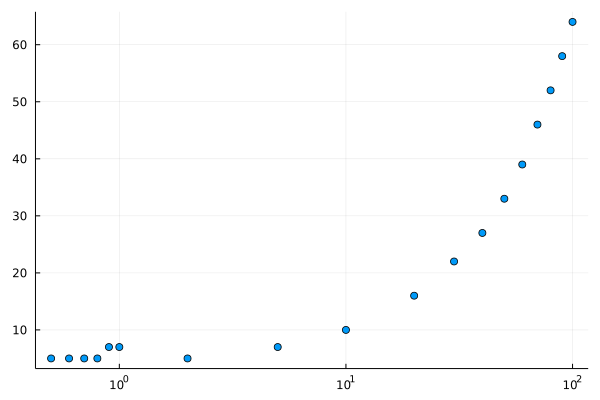

In [29]:
scatter(ρᵢ,iterations,xscale= :log10,legend=false,grid=true)

In [30]:
print(norms)

[0.06319623341024282, 0.06351309378576103, 0.06218816997772283, 0.060834676909234615, 0.0364288883360374, 0.010459715403412728, 0.0099595104481432, 0.0016156111689380073, 1.137212663558659e-8, 2.0472388578609263e-8, 0.00011050370719638187, 0.0010173256704376333, 0.0007002125301733701, 0.0006004089189567809, 1.8632778483668484e-9, 0.0004725906235219191, 0.000377650793220638, 0.00033548313634086056]

In [36]:
print(t)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]